# Setup

In [1]:
using DifferentialEquations, Plots, Turing, Interpolations, StatsPlots
using LightGraphs, MetaGraphs
using GraphRecipes

# Three node network

Adjacency matrix

In [2]:
num_nodes = 3

W = [0.0 0.2 0.0; 0.4 0.0 0.0; 0.0 0.3 0.0]

3×3 Array{Float64,2}:
 0.0  0.2  0.0
 0.4  0.0  0.0
 0.0  0.3  0.0

Plot the network

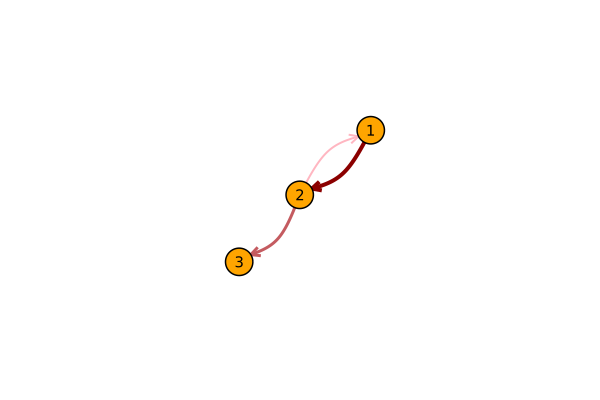

In [3]:
graph = SimpleDiGraph(3)
add_edge!(graph, 1,2)
add_edge!(graph, 2,1)
add_edge!(graph, 2,3)

metagraph = MetaDiGraph(graph)

set_prop!(metagraph, Edge(1,2), :weight, 4.0)
set_prop!(metagraph, Edge(2,1), :weight, 2.0)
set_prop!(metagraph, Edge(2,3), :weight, 3.0)

set_prop!(metagraph, 1, :name, "1")
set_prop!(metagraph, 2, :name, "2")
set_prop!(metagraph, 3, :name, "3")

graphplot(graph, nodesize=0.2, nodeshape=:circle,
    fontsize=10,
    edge_width=(s,d,w) -> get_prop(metagraph, Edge(s,d), :weight),
    line_z=reshape([4.; 2.; 3], 1, :),
    arrow=true,
    nodestrokewidth=1.5,
    nodecolor=:orange,
    edgecolor=:reds,
    curvature_scalar=0.1,
    names=[get_prop(metagraph,n,:name) for n in 1:size(metagraph)[1]],
    self_edge_size=1.0,
    axis_buffer=0.9
    )

Define sigmoid function

In [4]:
phi(a::Number) = (exp(2*a)-1)/(exp(2*a)+1)

phi (generic function with 1 method)

Define noise model

In [5]:
function additive_noise!(du,u,p,t)
    σ = p[length(p)] #make sure ϕ is the last value in the parameter array
    for i = 1:length(u)
        #This value multiplies a random number drawn from N(0, dt) i.e. noise then scales with sampling rate and effective sd of noise will be e.g. 0.1*dt
        du[i] = σ 
    end
end

additive_noise! (generic function with 1 method)

Define network propagation without stimulation

In [6]:
function no_input!(du,u,p,t)
    s,g,b,σ = p
    
    for i=1:length(u)
        du[i] = -u[i] + s*phi(u[i]) + g*(sum(W[i,:].*u))
    end
end

no_input! (generic function with 1 method)

Define network propagation **with** stimulation

In [7]:
function w_input!(du,u,p,t)
    s,g,b,σ = p
     
    for i=1:length(u)
        du[i] = -u[i] + s*phi(u[i]) + g*(sum(W[i,:].*u)) + b*I[i](t)
    end
end

w_input! (generic function with 1 method)

Define task structure for network that'll be stimulated

In [8]:
num_blocks = 4
on_len = 10
off_len = 10
stim = repeat([repeat([0.0], Int(off_len)); repeat([1.0], Int(on_len)); repeat([0.0], Int(off_len));], Int(num_blocks))
Tmax = length(stim)
nostim = repeat([0.0], Tmax)
ts = 1:1:Tmax
stim_node = 1
I = Array{Interpolations.FilledExtrapolation}(undef, 3)
for i=1:num_nodes
    if i==stim_node
        I[i] = LinearInterpolation(ts, stim, extrapolation_bc = 0)
    else
        I[i] = LinearInterpolation(ts, nostim, extrapolation_bc = 0)
    end
end

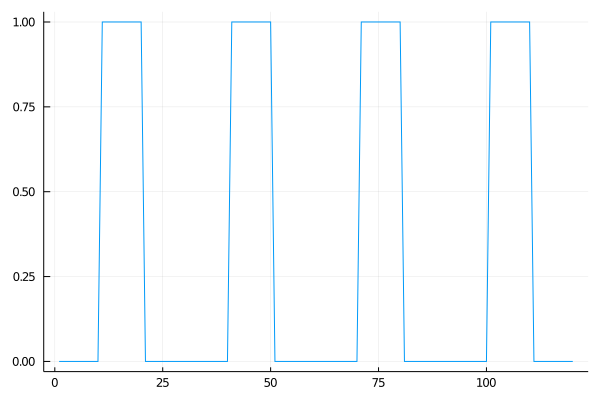

In [9]:
plot(stim, legend=false)

Define simulation parameters and SDE problems

In [10]:
u0 = repeat([0.0], num_nodes)
tspan = (0,Float64(Tmax))

dt = 0.25
# s,g,b,σ = p
p = [0.3, 0.7, 0.5, 0.01]

prob_noinput = SDEProblem(no_input!,additive_noise!,u0,tspan,p)
prob_winput = SDEProblem(w_input!,additive_noise!,u0,tspan,p)
# sol = solve(prob_sde, dt=dt, adaptive=false)
# plot(sol)

SDEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 120.0)
u0: [0.0, 0.0, 0.0]

Note: If you don't turn off adaptive step size for `solve` function then the number of solved points will not be Tmax/dt. It will be determined as detailed [here](https://diffeq.sciml.ai/stable/basics/common_solver_opts/#Basic-Stepsize-Control).

Generate 25 networks with 3 nodes and solve the SDE for each of them.

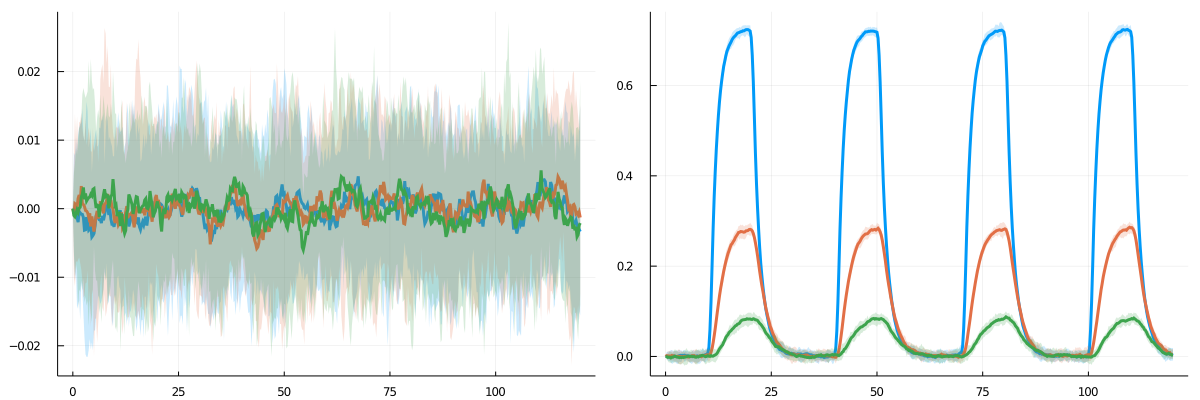

In [11]:
ens_noinput = EnsembleProblem(prob_noinput)
dat_noinput = solve(ens_noinput, SOSRI(), trajectories=25, dt=dt, adaptive=false)
ens_winput = EnsembleProblem(prob_winput)
dat_winput = solve(ens_winput, SOSRI(), trajectories=25, dt=dt, adaptive=false)
p1 = plot(EnsembleSummary(dat_noinput))
p2 = plot(EnsembleSummary(dat_winput))
plot(p1, p2, layout=(1,2), size=(1200, 400))

In [12]:
Turing.setadbackend(:forwarddiff)

:forwarddiff

In [13]:
@model function fit_noinput(data, prob)
    s ~ truncated(Normal(1.0,1.0),0.0,3.0)
    g ~ truncated(Normal(1.0,1.0),0.0,3.0)
    b = 0.0
    σ ~ truncated(Normal(0.0,1.0),-3.0,3.0)
    obs_noise ~ InverseGamma(2,3)
    
    p = [s,g,b,σ]

    prob = remake(prob, p=p)
    predicted = solve(prob, SOSRI(), dt=dt, adaptive=false)

    if predicted.retcode != :Success
        Turing.acclogp!(_varinfo, -Inf)
    end
    for j in 1:length(data) #number of ensemble iterations
        for i = 1:length(predicted) #number of time points
            data[j][i] ~ MvNormal(predicted[i], obs_noise) #generate 3 points at a time for each node
        end
    end
end;

┌ Warning: you are using the internal variable `_varinfo`
└ @ DynamicPPL /Users/zeynepenkavi/.julia/packages/DynamicPPL/wf0dU/src/compiler.jl:171


In [14]:
@model function fit_winput(data, prob)
    s ~ truncated(Normal(1.0,1.0),0.0,3.0)
    g ~ truncated(Normal(1.0,1.0),0.0,3.0)
    b ~ truncated(Normal(1.0,1.0),-3.0,3.0)
    σ ~ truncated(Normal(0.0,1.0),-3.0,3.0)
    obs_noise ~ InverseGamma(2,3)
    
    p = [s,g,b,σ]

    prob = remake(prob, p=p)
    predicted = solve(prob, SOSRI(), dt=dt, adaptive=false)

    if predicted.retcode != :Success
        Turing.acclogp!(_varinfo, -Inf)
    end
    for j in 1:length(data) #number of ensemble iterations
        for i = 1:length(predicted) #number of time points
            data[j][i] ~ MvNormal(predicted[i], obs_noise) #generate 3 points at a time for each node
        end
    end
end;

┌ Warning: you are using the internal variable `_varinfo`
└ @ DynamicPPL /Users/zeynepenkavi/.julia/packages/DynamicPPL/wf0dU/src/compiler.jl:171


In [15]:
mod_noinput = fit_noinput(dat_noinput, prob_noinput)
mod_winput = fit_winput(dat_winput, prob_winput)

DynamicPPL.Model{var"#7#8",(:data, :prob),(),(),Tuple{EnsembleSolution{Float64,3,Array{RODESolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},NoiseProcess{Float64,2,Float64,Array{Float64,1},Array{Float64,1},Array{Array{Float64,1},1},typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST),typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE),true,ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},RSWM{Float64},Nothing,RandomNumbers.Xorshifts.Xoroshiro128Plus},SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},Nothing,SDEFunction{true,typeof(w_input!),typeof(additive_noise!),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(additive_noise!),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},SOSRI,St

In [16]:
@time q_noinput = vi(mod_noinput, ADVI(10, 2000))

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 9845161520906701043
└ @ AdvancedVI /Users/zeynepenkavi/.julia/packages/AdvancedVI/8ttTK/src/AdvancedVI.jl:199
[ADVI] Optimizing...100% Time: 0:10:32


654.875754 seconds (7.28 G allocations: 460.586 GiB, 9.32% gc time)


Bijectors.TransformedDistribution{DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}},Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Bijectors.Exp{0}},4},Multivariate}(
dist: DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}}(m=[-8.36961548330162, -4.490561643322453, -0.00017774876677599527, -4.567175768663009], σ=[0.3681364301293092, 0.581190326408282, 0.00013354404129560505, 0.0076415721264406255])
transform: Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Bijectors.Exp{0}},4}((Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0}(Bijectors.TruncatedBijector{0,Float64,Float64}(0.0, 3.0)), Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0}(Bijectors.TruncatedBij

In [17]:
@time q_winput = vi(mod_winput, ADVI(10, 2000))

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 6554745463959282086
└ @ AdvancedVI /Users/zeynepenkavi/.julia/packages/AdvancedVI/8ttTK/src/AdvancedVI.jl:199
[ADVI] Optimizing...100% Time: 0:12:22


744.209294 seconds (8.04 G allocations: 524.719 GiB, 12.58% gc time)


Bijectors.TransformedDistribution{DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}},Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Bijectors.Exp{0}},5},Multivariate}(
dist: DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}}(
m: [-2.2085577276353705, -1.1843045487151507, 0.3373576625407355, -6.41654843484995e-5, -4.341520459972665]
σ: [0.0011329454375302887, 0.0015731551606115723, 0.0002539017636152572, 0.00020877061934424678, 0.015447839365673772]
)

transform: Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Bijectors.Exp{0}},5}((Inverse{Bijectors.TruncatedB

In [18]:
samp_noinput = rand(q_noinput, 10000)

4×10000 Array{Float64,2}:
 0.000731413   0.000574718   0.00108219   …   0.00117558    0.000876877
 0.0435192     0.00966338    0.0338497        0.0572684     0.0203662
 4.37467e-5   -0.000255548  -0.000207438     -0.000353648  -0.000163901
 0.0102485     0.0103546     0.010342         0.0103107     0.0103432

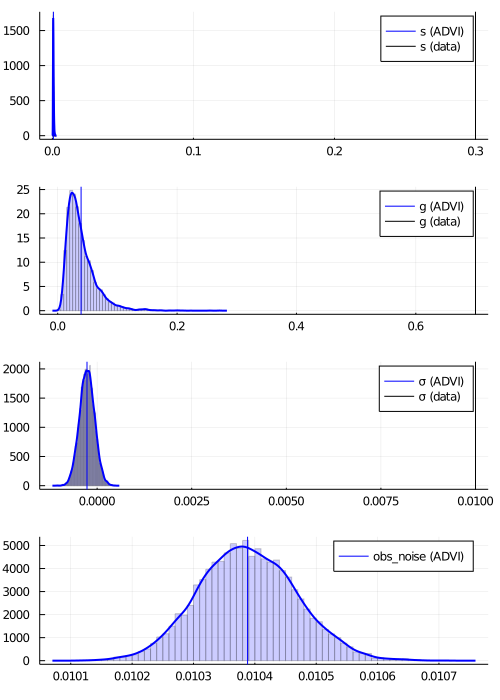

In [19]:
#The vector has the same ordering as the model
# s, g, σ, obs_noise
p1 = histogram(samp_noinput[1, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_noinput[1, :], label = "s (ADVI)", color = :blue, linewidth = 2)
vline!([p[1]], label = "s (data)", color = :black)
vline!([mean(samp_noinput[1, :])], color = :blue, label ="")

p2 = histogram(samp_noinput[2, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_noinput[2, :], label = "g (ADVI)", color = :blue, linewidth = 2)
vline!([p[2]], label = "g (data)", color = :black)
vline!([mean(samp_noinput[2, :])], color = :blue, label ="")

p3 = histogram(samp_noinput[3, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_noinput[3, :], label = "σ (ADVI)", color = :blue, linewidth = 2)
vline!([p[4]], label = "σ (data)", color = :black)
vline!([mean(samp_noinput[3, :])], color = :blue, label ="")

p4 = histogram(samp_noinput[4, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_noinput[4, :], label = "obs_noise (ADVI)", color = :blue, linewidth = 2)
vline!([mean(samp_noinput[4, :])], color = :blue, label ="")

plot(p1, p2, p3, p4, layout=(4,1), size=(500, 700))

In [20]:
samp_winput = rand(q_winput, 10000)

5×10000 Array{Float64,2}:
 0.29701      0.296532     0.296788     …   0.297579     0.296815
 0.702405     0.703305     0.702738         0.701529     0.703364
 0.501479     0.502093     0.501726         0.501198     0.500936
 0.00028785  -0.000395955  0.000160796     -0.000372969  0.0001088
 0.0127012    0.0129655    0.0131376        0.0132593    0.0129188

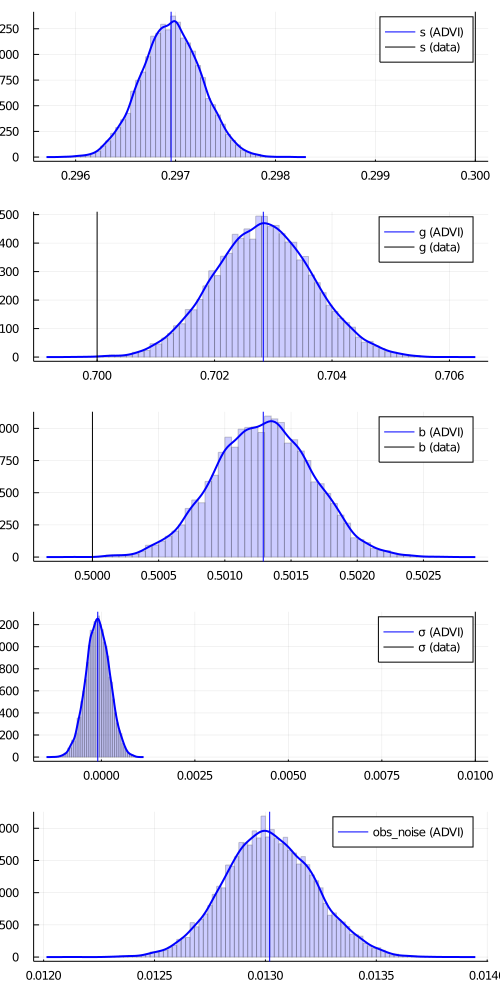

In [21]:
#The vector has the same ordering as the model
# s, g, b, σ, obs_noise
p1 = histogram(samp_winput[1, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_winput[1, :], label = "s (ADVI)", color = :blue, linewidth = 2)
vline!([p[1]], label = "s (data)", color = :black)
vline!([mean(samp_winput[1, :])], color = :blue, label ="")

p2 = histogram(samp_winput[2, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_winput[2, :], label = "g (ADVI)", color = :blue, linewidth = 2)
vline!([p[2]], label = "g (data)", color = :black)
vline!([mean(samp_winput[2, :])], color = :blue, label ="")

p3 = histogram(samp_winput[3, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_winput[3, :], label = "b (ADVI)", color = :blue, linewidth = 2)
vline!([p[3]], label = "b (data)", color = :black)
vline!([mean(samp_winput[3, :])], color = :blue, label ="")

p4 = histogram(samp_winput[4, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_winput[4, :], label = "σ (ADVI)", color = :blue, linewidth = 2)
vline!([p[4]], label = "σ (data)", color = :black)
vline!([mean(samp_winput[4, :])], color = :blue, label ="")

p5 = histogram(samp_winput[5, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_winput[5, :], label = "obs_noise (ADVI)", color = :blue, linewidth = 2)
vline!([mean(samp_winput[5, :])], color = :blue, label ="")

plot(p1, p2, p3, p4, p5, layout=(5,1), size=(500, 1000))

Does it make sense to look at the correlation between parameters? I don't think so because VI has the independence assumption between parameters so the correlation should be 0. See example below of samples from `s` and `g`

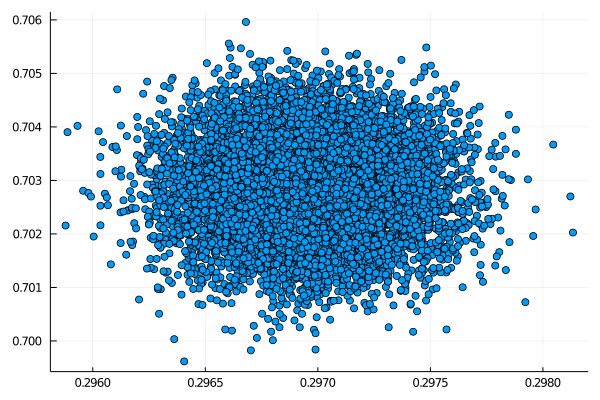

In [24]:
scatter(samp_winput[1,:], samp_winput[2,:], legend=false)

<font color='red'>**Likelihood surface? How would we calculate the likelihood?**<font>

What is b estimated if you just regress the timeseries on the task vector?  

Define output array `betas = Array{Float64}(undef, 25)`
Loop through the 25 tracjectories
For each trajectory:
- extract the first nodes time series into a dataframe `tmp_dat = DataFrame(node_ts = getindex.(dat_winput[i].u,1))`
- make column for time point `tmp_dat.time_point = 1:size(tmp_dat)[1]`
- add column for upsampled stim timeseries using I[1](time point) `tmp_dat.stim = `
- regress node time series onto stim timeseries
- extract and store beta
Output: array of betas for each trajectory (length = 25)

In [54]:
tmp = DataFrame(X=[1,2,3], Y=[2,4,7])

,X,Y
,Int64,Int64
1,1,2
2,2,4
3,3,7


In [61]:
typeof(size(tmp)[1])

Int64

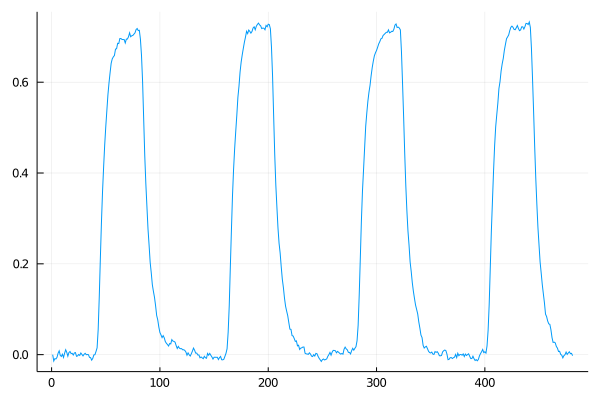

In [44]:
plot(getindex.(dat_winput[1].u,1), legend=false)

In [53]:
using DataFrames, GLM

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1278
┌ Info: Precompiling GLM [38e38edf-8417-5370-95a0-9cbb8c7f171a]
└ @ Base loading.jl:1278


In [48]:
I[1](50.5)

0.5

b's should be different for each node! Updated model with node-specific task parameters.

In [ ]:
function diff_betas!(du,u,p,t)
    s,g,b1,b2,b3,σ = p
    
    du[1] = -u[1] + s*phi(u[1]) + g*(sum(W[1,:].*u)) + b1*I[1](t)
    du[2] = -u[2] + s*phi(u[2]) + g*(sum(W[2,:].*u)) + b2*I[3](t)
    du[3] = -u[3] + s*phi(u[3]) + g*(sum(W[3,:].*u)) + b3*I[3](t)
end

#b's for non stim nodes are set to 0.5 but since the I[node] is 0 it shouldn't be identifiable
p = [0.3, 0.7, 0.5, 0.5, 0.5, 0.01]

prob_diff_betas = SDEProblem(diff_betas!,additive_noise!,u0,tspan,p)

ens_diff_betas = EnsembleProblem(prob_diff_betas)
dat_diff_betas = solve(ens_diff_betas, SOSRI(), trajectories=25, dt=dt, adaptive=false)

@model function fit_diff_betas(data, prob)
    s ~ truncated(Normal(1.0,1.0),0.0,3.0)
    g ~ truncated(Normal(1.0,1.0),0.0,3.0)
    b1 ~ truncated(Normal(1.0,1.0),-3.0,3.0)
    b2 ~ truncated(Normal(1.0,1.0),-3.0,3.0)
    b3 ~ truncated(Normal(1.0,1.0),-3.0,3.0)
    σ ~ truncated(Normal(0.0,1.0),-3.0,3.0)
    obs_noise ~ InverseGamma(2,3)
    
    p = [s,g,b1,b2,b3,σ]

    prob = remake(prob, p=p)
    predicted = solve(prob, SOSRI(), dt=dt, adaptive=false)

    if predicted.retcode != :Success
        Turing.acclogp!(_varinfo, -Inf)
    end
    for j in 1:length(data) #number of ensemble iterations
        for i = 1:length(predicted) #number of time points
            data[j][i] ~ MvNormal(predicted[i], obs_noise) #generate 3 points at a time for each node
        end
    end
end;

mod_diff_betas = fit_winput(dat_diff_betas, prob_diff_betas)
@time q_diff_betas = vi(mod_diff_betas, ADVI(10, 2000))


In [ ]:
samp_diff_betas = rand(q_diff_betas, 10000)